In [3]:
# Import Library
import pandas as pd

from datetime import datetime

from datetime import timedelta, date

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

import seaborn as sns

# Data Preprocessing
import pickle as pkl

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

# Model Architecture
import numpy as np
# from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import activations
import tensorflow as tf
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

import sys
from sys import exit

import matplotlib.pyplot as plt
from IPython.display import display
# from IPython.display import HTML
# import tabulate

# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.metrics import r2_score

from keras.models import load_model

from keras.backend import clear_session

import time

import math

In [4]:
# Load Training and Validation Data
train_data = pd.read_csv('train.csv')


In [5]:
train_data.head()

,id,date,speed
0,0,1/1/2017 0:00,43.002930
1,1,1/1/2017 1:00,46.118696
2,2,1/1/2017 2:00,44.294158
3,3,1/1/2017 3:00,41.067468
4,4,1/1/2017 4:00,46.448653


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14006 non-null  int64  
 1   date    14006 non-null  object 
 2   speed   14006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 328.4+ KB


In [7]:
train_data.describe()

,id,speed
count,14006.00000,14006.000000
mean,7002.50000,32.779118
std,4043.32827,13.573813
min,0.00000,2.573417
25%,3501.25000,19.301089
50%,7002.50000,36.580595
75%,10503.75000,45.877665
max,14005.00000,53.161286


In [8]:
train_data.isna().sum()

id       0
date     0
speed    0
dtype: int64

In [9]:
# Load 2017 and 2018 Public Holiday Data

ph_data = pd.read_csv('2017_2018PublicHolidayWithoutSunday.csv')

ph_data['date'] = pd.to_datetime(ph_data['date'], format='%d/%m/%Y')

In [10]:
ph_data

,date
0,2017-01-02
1,2017-01-28
2,2017-01-30
3,2017-01-31
4,2017-04-04
5,2017-04-14
6,2017-04-15
7,2017-04-17
8,2017-05-01
9,2017-05-03


In [11]:
ph_data.head()

,date
0,2017-01-02
1,2017-01-28
2,2017-01-30
3,2017-01-31
4,2017-04-04


In [12]:
ph_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    35 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 408.0 bytes


In [13]:
ph_data.isna().sum()

date    0
dtype: int64

In [14]:
def dataPreparation(data):
  result = pd.DataFrame()
  result = data
  result['date'] = pd.to_datetime(result['date'], format='%d/%m/%Y %H:%M')

  # Extract Date from DateTime
  result['dateonly'] = result['date'].dt.date

  # Extract Year from DateTime
  result['year'] = result['date'].dt.year
  result = pd.get_dummies(result, columns=['year'])

  # Extract Month from DateTime
  result['month'] = result['date'].dt.month_name()
  result = pd.get_dummies(result, columns=['month'])

  # Extract Weekday (Monday to Sunday) from DateTime
  result['weekday'] = result['date'].dt.day_name()
  result = pd.get_dummies(result, columns=['weekday'])

  # Extract Weekday or Weekend from DateTime
  # result['weekend'] = ((pd.DatetimeIndex(result.date).dayofweek) // 5 == 1).astype(int)

  # Extract Time from DateTime
  result['hour'] = result['date'].dt.strftime('%H')
  result = pd.get_dummies(result, columns=['hour'])

  # The Date is Public Holiday (What is the definition? Sun? Sat?)
  holiday_dict = {}
  for index, holiday in ph_data['date'].items():
    holiday_dict[holiday] = 1

  result['holiday']= result['dateonly'].map(holiday_dict)
  result['holiday'] = result['holiday'].replace(np.nan, 0)

  # Tomorrow is Purlic Holiday
  tmrHoliday_dict = {}
  for index, holiday in ph_data['date'].items():
    tmrHoliday_dict[holiday - timedelta(days=1)] = 1

  result['tmrHoliday']= result['dateonly'].map(tmrHoliday_dict)
  result['tmrHoliday'] = result['tmrHoliday'].replace(np.nan, 0)

  # Yesterday is Purlic Holiday
  ydHoliday_dict = {}
  for index, holiday in ph_data['date'].items():
    ydHoliday_dict[holiday + timedelta(days=1)] = 1

  result['ydHoliday']= result['dateonly'].map(ydHoliday_dict)
  result['ydHoliday'] = result['ydHoliday'].replace(np.nan, 0)
  return result

In [15]:
train_data = dataPreparation(train_data)

In [16]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns',None)

In [17]:
train_data

,id,date,speed,dateonly,year_2017,year_2018,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday,tmrHoliday,ydHoliday
0,0,2017-01-01 00:00:00,43.002930,2017-01-01,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0
1,1,2017-01-01 01:00:00,46.118696,2017-01-01,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0
2,2,2017-01-01 02:00:00,44.294158,2017-01-01,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0
3,3,2017-01-01 03:00:00,41.067468,2017-01-01,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0
4,4,2017-01-01 04:00:00,46.448653,2017-01-01,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,14001,2018-12-31 12:00:00,19.865269,2018-12-31,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0
14002,14002,2018-12-31 15:00:00,17.820375,2018-12-31,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0.0
14003,14003,2018-12-31 16:00:00,12.501851,2018-12-31,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0
14004,14004,2018-12-31 18:00:00,15.979319,2018-12-31,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0


In [18]:
# pd.set_option('display.max_rows', 60)
# pd.set_option('display.max_columns', 60)

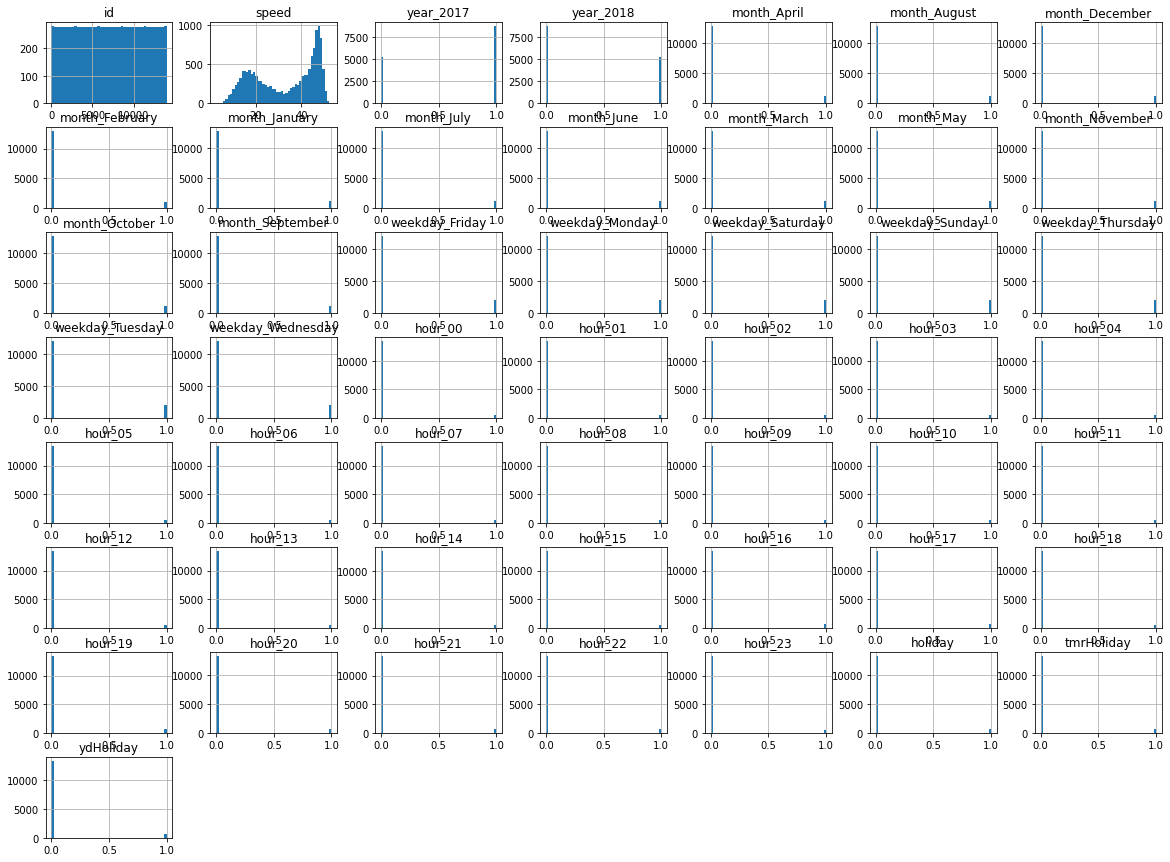

In [19]:
train_data.hist(bins=50,figsize=(20,15))
plt.show()

In [20]:
train_data['speedRange'] = np.where(train_data['speed'] < 10, 'below_10', np.where(train_data['speed'] < 20, 's10_20', np.where(train_data['speed'] < 30, 's20_30', np.where(train_data['speed'] < 40, 's30_40', np.where(train_data['speed'] < 50, 's40_50', 'above_50')))))

In [21]:
def groupSpeedRange(refColumn):
  refColumn_below_10 = len(train_data.loc[train_data[refColumn] == 1].loc[train_data['speedRange'] == 'below_10'])
  refColumn_10_20 = len(train_data.loc[train_data[refColumn] == 1].loc[train_data['speedRange'] == 's10_20'])
  refColumn_20_30 = len(train_data.loc[train_data[refColumn] == 1].loc[train_data['speedRange'] == 's20_30'])
  refColumn_30_40 = len(train_data.loc[train_data[refColumn] == 1].loc[train_data['speedRange'] == 's30_40'])
  refColumn_40_50 = len(train_data.loc[train_data[refColumn] == 1].loc[train_data['speedRange'] == 's40_50'])
  refColumn_above_50 = len(train_data.loc[train_data[refColumn] == 1].loc[train_data['speedRange'] == 'above_50'])
  return refColumn_below_10, refColumn_10_20, refColumn_20_30, refColumn_30_40, refColumn_40_50, refColumn_above_50

In [22]:
y2017_below_10, y2017_10_20, y2017_20_30, y2017_30_40, y2017_40_50, y2017_above_50 = groupSpeedRange('year_2017')
y2018_below_10, y2018_10_20, y2018_20_30, y2018_30_40, y2018_40_50, y2018_above_50 = groupSpeedRange('year_2018')

In [23]:
january_below_10, january_10_20, january_20_30, january_30_40, january_40_50, january_above_50 = groupSpeedRange('month_January')
february_below_10, february_10_20, february_20_30, february_30_40, february_40_50, february_above_50 = groupSpeedRange('month_February')
march_below_10, march_10_20, march_20_30, march_30_40, march_40_50, march_above_50 = groupSpeedRange('month_March')
april_below_10, april_10_20, april_20_30, april_30_40, april_40_50, april_above_50 = groupSpeedRange('month_April')
may_below_10, may_10_20, may_20_30, may_30_40, may_40_50, may_above_50 = groupSpeedRange('month_May')
june_below_10, june_10_20, june_20_30, june_30_40, june_40_50, june_above_50 = groupSpeedRange('month_June')
july_below_10, july_10_20, july_20_30, july_30_40, july_40_50, july_above_50 = groupSpeedRange('month_July')
august_below_10, august_10_20, august_20_30, august_30_40, august_40_50, august_above_50 = groupSpeedRange('month_August')
september_below_10, september_10_20, september_20_30, september_30_40, september_40_50, september_above_50 = groupSpeedRange('month_September')
october_below_10, october_10_20, october_20_30, october_30_40, october_40_50, october_above_50 = groupSpeedRange('month_October')
november_below_10, november_10_20, november_20_30, november_30_40, november_40_50, november_above_50 = groupSpeedRange('month_November')
december_below_10, december_10_20, december_20_30, december_30_40, december_40_50, december_above_50 = groupSpeedRange('month_December')

In [24]:
monday_below_10 = len(train_data.loc[train_data['weekday_Monday'] == 1].loc[train_data['speedRange'] == 'below_10'])
monday_10_20 = len(train_data.loc[train_data['weekday_Monday'] == 1].loc[train_data['speedRange'] == 's10_20'])
monday_20_30 = len(train_data.loc[train_data['weekday_Monday'] == 1].loc[train_data['speedRange'] == 's20_30'])
monday_30_40 = len(train_data.loc[train_data['weekday_Monday'] == 1].loc[train_data['speedRange'] == 's30_40'])
monday_40_50 = len(train_data.loc[train_data['weekday_Monday'] == 1].loc[train_data['speedRange'] == 's40_50'])
monday_above_50 = len(train_data.loc[train_data['weekday_Monday'] == 1].loc[train_data['speedRange'] == 'above_50'])

tuesday_below_10 = len(train_data.loc[train_data['weekday_Tuesday'] == 1].loc[train_data['speedRange'] == 'below_10'])
tuesday_10_20 = len(train_data.loc[train_data['weekday_Tuesday'] == 1].loc[train_data['speedRange'] == 's10_20'])
tuesday_20_30 = len(train_data.loc[train_data['weekday_Tuesday'] == 1].loc[train_data['speedRange'] == 's20_30'])
tuesday_30_40 = len(train_data.loc[train_data['weekday_Tuesday'] == 1].loc[train_data['speedRange'] == 's30_40'])
tuesday_40_50 = len(train_data.loc[train_data['weekday_Tuesday'] == 1].loc[train_data['speedRange'] == 's40_50'])
tuesday_above_50 = len(train_data.loc[train_data['weekday_Tuesday'] == 1].loc[train_data['speedRange'] == 'above_50'])

wednesday_below_10 = len(train_data.loc[train_data['weekday_Wednesday'] == 1].loc[train_data['speedRange'] == 'below_10'])
wednesday_10_20 = len(train_data.loc[train_data['weekday_Wednesday'] == 1].loc[train_data['speedRange'] == 's10_20'])
wednesday_20_30 = len(train_data.loc[train_data['weekday_Wednesday'] == 1].loc[train_data['speedRange'] == 's20_30'])
wednesday_30_40 = len(train_data.loc[train_data['weekday_Wednesday'] == 1].loc[train_data['speedRange'] == 's30_40'])
wednesday_40_50 = len(train_data.loc[train_data['weekday_Wednesday'] == 1].loc[train_data['speedRange'] == 's40_50'])
wednesday_above_50 = len(train_data.loc[train_data['weekday_Wednesday'] == 1].loc[train_data['speedRange'] == 'above_50'])

thursday_below_10 = len(train_data.loc[train_data['weekday_Thursday'] == 1].loc[train_data['speedRange'] == 'below_10'])
thursday_10_20 = len(train_data.loc[train_data['weekday_Thursday'] == 1].loc[train_data['speedRange'] == 's10_20'])
thursday_20_30 = len(train_data.loc[train_data['weekday_Thursday'] == 1].loc[train_data['speedRange'] == 's20_30'])
thursday_30_40 = len(train_data.loc[train_data['weekday_Thursday'] == 1].loc[train_data['speedRange'] == 's30_40'])
thursday_40_50 = len(train_data.loc[train_data['weekday_Thursday'] == 1].loc[train_data['speedRange'] == 's40_50'])
thursday_above_50 = len(train_data.loc[train_data['weekday_Thursday'] == 1].loc[train_data['speedRange'] == 'above_50'])

friday_below_10 = len(train_data.loc[train_data['weekday_Friday'] == 1].loc[train_data['speedRange'] == 'below_10'])
friday_10_20 = len(train_data.loc[train_data['weekday_Friday'] == 1].loc[train_data['speedRange'] == 's10_20'])
friday_20_30 = len(train_data.loc[train_data['weekday_Friday'] == 1].loc[train_data['speedRange'] == 's20_30'])
friday_30_40 = len(train_data.loc[train_data['weekday_Friday'] == 1].loc[train_data['speedRange'] == 's30_40'])
friday_40_50 = len(train_data.loc[train_data['weekday_Friday'] == 1].loc[train_data['speedRange'] == 's40_50'])
friday_above_50 = len(train_data.loc[train_data['weekday_Friday'] == 1].loc[train_data['speedRange'] == 'above_50'])

saturday_below_10 = len(train_data.loc[train_data['weekday_Saturday'] == 1].loc[train_data['speedRange'] == 'below_10'])
saturday_10_20 = len(train_data.loc[train_data['weekday_Saturday'] == 1].loc[train_data['speedRange'] == 's10_20'])
saturday_20_30 = len(train_data.loc[train_data['weekday_Saturday'] == 1].loc[train_data['speedRange'] == 's20_30'])
saturday_30_40 = len(train_data.loc[train_data['weekday_Saturday'] == 1].loc[train_data['speedRange'] == 's30_40'])
saturday_40_50 = len(train_data.loc[train_data['weekday_Saturday'] == 1].loc[train_data['speedRange'] == 's40_50'])
saturday_above_50 = len(train_data.loc[train_data['weekday_Saturday'] == 1].loc[train_data['speedRange'] == 'above_50'])

sunday_below_10 = len(train_data.loc[train_data['weekday_Sunday'] == 1].loc[train_data['speedRange'] == 'below_10'])
sunday_10_20 = len(train_data.loc[train_data['weekday_Sunday'] == 1].loc[train_data['speedRange'] == 's10_20'])
sunday_20_30 = len(train_data.loc[train_data['weekday_Sunday'] == 1].loc[train_data['speedRange'] == 's20_30'])
sunday_30_40 = len(train_data.loc[train_data['weekday_Sunday'] == 1].loc[train_data['speedRange'] == 's30_40'])
sunday_40_50 = len(train_data.loc[train_data['weekday_Sunday'] == 1].loc[train_data['speedRange'] == 's40_50'])
sunday_above_50 = len(train_data.loc[train_data['weekday_Sunday'] == 1].loc[train_data['speedRange'] == 'above_50'])

holiday_below_10 = len(train_data.loc[(train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 1)].loc[train_data['speedRange'] == 'below_10'])
holiday_10_20 = len(train_data.loc[(train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 1)].loc[train_data['speedRange'] == 's10_20'])
holiday_20_30 = len(train_data.loc[(train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 1)].loc[train_data['speedRange'] == 's20_30'])
holiday_30_40 = len(train_data.loc[(train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 1)].loc[train_data['speedRange'] == 's30_40'])
holiday_40_50 = len(train_data.loc[(train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 1)].loc[train_data['speedRange'] == 's40_50'])
holiday_above_50 = len(train_data.loc[(train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 1)].loc[train_data['speedRange'] == 'above_50'])

tmrHoliday_below_10 = len(train_data.loc[(train_data['weekday_Saturday'] == 0) & (train_data['tmrHoliday'] == 1)].loc[train_data['speedRange'] == 'below_10'])
tmrHoliday_10_20 = len(train_data.loc[(train_data['weekday_Saturday'] == 0) & (train_data['tmrHoliday'] == 1)].loc[train_data['speedRange'] == 's10_20'])
tmrHoliday_20_30 = len(train_data.loc[(train_data['weekday_Saturday'] == 0) & (train_data['tmrHoliday'] == 1)].loc[train_data['speedRange'] == 's20_30'])
tmrHoliday_30_40 = len(train_data.loc[(train_data['weekday_Saturday'] == 0) & (train_data['tmrHoliday'] == 1)].loc[train_data['speedRange'] == 's30_40'])
tmrHoliday_40_50 = len(train_data.loc[(train_data['weekday_Saturday'] == 0) & (train_data['tmrHoliday'] == 1)].loc[train_data['speedRange'] == 's40_50'])
tmrHoliday_above_50 = len(train_data.loc[(train_data['weekday_Saturday'] == 0) & (train_data['tmrHoliday'] == 1)].loc[train_data['speedRange'] == 'above_50'])

ydHoliday_below_10 = len(train_data.loc[(train_data['weekday_Monday'] == 0) & (train_data['ydHoliday'] == 1)].loc[train_data['speedRange'] == 'below_10'])
ydHoliday_10_20 = len(train_data.loc[(train_data['weekday_Monday'] == 0) & (train_data['ydHoliday'] == 1)].loc[train_data['speedRange'] == 's10_20'])
ydHoliday_20_30 = len(train_data.loc[(train_data['weekday_Monday'] == 0) & (train_data['ydHoliday'] == 1)].loc[train_data['speedRange'] == 's20_30'])
ydHoliday_30_40 = len(train_data.loc[(train_data['weekday_Monday'] == 0) & (train_data['ydHoliday'] == 1)].loc[train_data['speedRange'] == 's30_40'])
ydHoliday_40_50 = len(train_data.loc[(train_data['weekday_Monday'] == 0) & (train_data['ydHoliday'] == 1)].loc[train_data['speedRange'] == 's40_50'])
ydHoliday_above_50 = len(train_data.loc[(train_data['weekday_Monday'] == 0) & (train_data['ydHoliday'] == 1)].loc[train_data['speedRange'] == 'above_50'])

notHoliday_below_10 = len(train_data.loc[(train_data['holiday'] == 0) & (train_data['tmrHoliday'] == 0) & (train_data['ydHoliday'] == 0)].loc[train_data['speedRange'] == 'below_10'])
notHoliday_10_20 = len(train_data.loc[(train_data['holiday'] == 0) & (train_data['tmrHoliday'] == 0) & (train_data['ydHoliday'] == 0)].loc[train_data['speedRange'] == 's10_20'])
notHoliday_20_30 = len(train_data.loc[(train_data['holiday'] == 0) & (train_data['tmrHoliday'] == 0) & (train_data['ydHoliday'] == 0)].loc[train_data['speedRange'] == 's20_30'])
notHoliday_30_40 = len(train_data.loc[(train_data['holiday'] == 0) & (train_data['tmrHoliday'] == 0) & (train_data['ydHoliday'] == 0)].loc[train_data['speedRange'] == 's30_40'])
notHoliday_40_50 = len(train_data.loc[(train_data['holiday'] == 0) & (train_data['tmrHoliday'] == 0) & (train_data['ydHoliday'] == 0)].loc[train_data['speedRange'] == 's40_50'])
notHoliday_above_50 = len(train_data.loc[(train_data['holiday'] == 0) & (train_data['tmrHoliday'] == 0) & (train_data['ydHoliday'] == 0)].loc[train_data['speedRange'] == 'above_50'])


In [25]:
def toPercentage(one, two, three, four, five, six):
  total = one + two + three + four + five + six
  one = one / total * 100
  two = two / total * 100
  three = three / total * 100
  four = four / total * 100
  five = five / total * 100
  six = six / total * 100
  return one, two, three, four, five, six

In [26]:
y2017_below_10, y2017_10_20, y2017_20_30, y2017_30_40, y2017_40_50, y2017_above_50 = toPercentage(y2017_below_10, y2017_10_20, y2017_20_30, y2017_30_40, y2017_40_50, y2017_above_50)
y2018_below_10, y2018_10_20, y2018_20_30, y2018_30_40, y2018_40_50, y2018_above_50 = toPercentage(y2018_below_10, y2018_10_20, y2018_20_30, y2018_30_40, y2018_40_50, y2018_above_50)

In [27]:
january_below_10, january_10_20, january_20_30, january_30_40, january_40_50, january_above_50 = toPercentage(january_below_10, january_10_20, january_20_30, january_30_40, january_40_50, january_above_50)
february_below_10, february_10_20, february_20_30, february_30_40, february_40_50, february_above_50 = toPercentage(february_below_10, february_10_20, february_20_30, february_30_40, february_40_50, february_above_50)
march_below_10, march_10_20, march_20_30, march_30_40, march_40_50, march_above_50 = toPercentage(march_below_10, march_10_20, march_20_30, march_30_40, march_40_50, march_above_50)
april_below_10, april_10_20, april_20_30, april_30_40, april_40_50, april_above_50 = toPercentage(april_below_10, april_10_20, april_20_30, april_30_40, april_40_50, april_above_50)
may_below_10, may_10_20, may_20_30, may_30_40, may_40_50, may_above_50 = toPercentage(may_below_10, may_10_20, may_20_30, may_30_40, may_40_50, may_above_50)
june_below_10, june_10_20, june_20_30, june_30_40, june_40_50, june_above_50 = toPercentage(june_below_10, june_10_20, june_20_30, june_30_40, june_40_50, june_above_50)
july_below_10, july_10_20, july_20_30, july_30_40, july_40_50, july_above_50 = toPercentage(july_below_10, july_10_20, july_20_30, july_30_40, july_40_50, july_above_50)
august_below_10, august_10_20, august_20_30, august_30_40, august_40_50, august_above_50 = toPercentage(august_below_10, august_10_20, august_20_30, august_30_40, august_40_50, august_above_50)
september_below_10, september_10_20, september_20_30, september_30_40, september_40_50, september_above_50 = toPercentage(september_below_10, september_10_20, september_20_30, september_30_40, september_40_50, september_above_50)
october_below_10, october_10_20, october_20_30, october_30_40, october_40_50, october_above_50 = toPercentage(october_below_10, october_10_20, october_20_30, october_30_40, october_40_50, october_above_50)
november_below_10, november_10_20, november_20_30, november_30_40, november_40_50, november_above_50 = toPercentage(november_below_10, november_10_20, november_20_30, november_30_40, november_40_50, november_above_50)
december_below_10, december_10_20, december_20_30, december_30_40, december_40_50, december_above_50 = toPercentage(december_below_10, december_10_20, december_20_30, december_30_40, december_40_50, december_above_50)

In [28]:
monday_below_10, monday_10_20, monday_20_30, monday_30_40, monday_40_50, monday_above_50 = toPercentage(monday_below_10, monday_10_20, monday_20_30, monday_30_40, monday_40_50, monday_above_50)
ydHoliday_below_10, ydHoliday_10_20, ydHoliday_20_30, ydHoliday_30_40, ydHoliday_40_50, ydHoliday_above_50 = toPercentage(ydHoliday_below_10, ydHoliday_10_20, ydHoliday_20_30, ydHoliday_30_40, ydHoliday_40_50, ydHoliday_above_50)
tuesday_below_10, tuesday_10_20, tuesday_20_30, tuesday_30_40, tuesday_40_50, tuesday_above_50 = toPercentage(tuesday_below_10, tuesday_10_20, tuesday_20_30, tuesday_30_40, tuesday_40_50, tuesday_above_50)
wednesday_below_10, wednesday_10_20, wednesday_20_30, wednesday_30_40, wednesday_40_50, wednesday_above_50 = toPercentage(wednesday_below_10, wednesday_10_20, wednesday_20_30, wednesday_30_40, wednesday_40_50, wednesday_above_50)
thursday_below_10, thursday_10_20, thursday_20_30, thursday_30_40, thursday_40_50, thursday_above_50 = toPercentage(thursday_below_10, thursday_10_20, thursday_20_30, thursday_30_40, thursday_40_50, thursday_above_50)
friday_below_10, friday_10_20, friday_20_30, friday_30_40, friday_40_50, friday_above_50 = toPercentage(friday_below_10, friday_10_20, friday_20_30, friday_30_40, friday_40_50, friday_above_50)
saturday_below_10, saturday_10_20, saturday_20_30, saturday_30_40, saturday_40_50, saturday_above_50 = toPercentage(saturday_below_10, saturday_10_20, saturday_20_30, saturday_30_40, saturday_40_50, saturday_above_50)
tmrHoliday_below_10, tmrHoliday_10_20, tmrHoliday_20_30, tmrHoliday_30_40, tmrHoliday_40_50, tmrHoliday_above_50 = toPercentage(tmrHoliday_below_10, tmrHoliday_10_20, tmrHoliday_20_30, tmrHoliday_30_40, tmrHoliday_40_50, tmrHoliday_above_50)
sunday_below_10, sunday_10_20, sunday_20_30, sunday_30_40, sunday_40_50, sunday_above_50 = toPercentage(sunday_below_10, sunday_10_20, sunday_20_30, sunday_30_40, sunday_40_50, sunday_above_50)
holiday_below_10, holiday_10_20, holiday_20_30, holiday_30_40, holiday_40_50, holiday_above_50 = toPercentage(holiday_below_10, holiday_10_20, holiday_20_30, holiday_30_40, holiday_40_50, holiday_above_50)
notHoliday_below_10, notHoliday_10_20, notHoliday_20_30, notHoliday_30_40, notHoliday_40_50, notHoliday_above_50 = toPercentage(notHoliday_below_10, notHoliday_10_20, notHoliday_20_30, notHoliday_30_40, notHoliday_40_50, notHoliday_above_50)

In [29]:
hour_00_below_10, hour_00_10_20, hour_00_20_30, hour_00_30_40, hour_00_40_50, hour_00_above_50 = groupSpeedRange('hour_00')
hour_00_below_10, hour_00_10_20, hour_00_20_30, hour_00_30_40, hour_00_40_50, hour_00_above_50 = toPercentage(hour_00_below_10, hour_00_10_20, hour_00_20_30, hour_00_30_40, hour_00_40_50, hour_00_above_50)
hour_01_below_10, hour_01_10_20, hour_01_20_30, hour_01_30_40, hour_01_40_50, hour_01_above_50 = groupSpeedRange('hour_01')
hour_01_below_10, hour_01_10_20, hour_01_20_30, hour_01_30_40, hour_01_40_50, hour_01_above_50 = toPercentage(hour_01_below_10, hour_01_10_20, hour_01_20_30, hour_01_30_40, hour_01_40_50, hour_01_above_50)
hour_02_below_10, hour_02_10_20, hour_02_20_30, hour_02_30_40, hour_02_40_50, hour_02_above_50 = groupSpeedRange('hour_02')
hour_02_below_10, hour_02_10_20, hour_02_20_30, hour_02_30_40, hour_02_40_50, hour_02_above_50 = toPercentage(hour_02_below_10, hour_02_10_20, hour_02_20_30, hour_02_30_40, hour_02_40_50, hour_02_above_50)
hour_03_below_10, hour_03_10_20, hour_03_20_30, hour_03_30_40, hour_03_40_50, hour_03_above_50 = groupSpeedRange('hour_03')
hour_03_below_10, hour_03_10_20, hour_03_20_30, hour_03_30_40, hour_03_40_50, hour_03_above_50 = toPercentage(hour_03_below_10, hour_03_10_20, hour_03_20_30, hour_03_30_40, hour_03_40_50, hour_03_above_50)
hour_04_below_10, hour_04_10_20, hour_04_20_30, hour_04_30_40, hour_04_40_50, hour_04_above_50 = groupSpeedRange('hour_04')
hour_04_below_10, hour_04_10_20, hour_04_20_30, hour_04_30_40, hour_04_40_50, hour_04_above_50 = toPercentage(hour_04_below_10, hour_04_10_20, hour_04_20_30, hour_04_30_40, hour_04_40_50, hour_04_above_50)
hour_05_below_10, hour_05_10_20, hour_05_20_30, hour_05_30_40, hour_05_40_50, hour_05_above_50 = groupSpeedRange('hour_05')
hour_05_below_10, hour_05_10_20, hour_05_20_30, hour_05_30_40, hour_05_40_50, hour_05_above_50 = toPercentage(hour_05_below_10, hour_05_10_20, hour_05_20_30, hour_05_30_40, hour_05_40_50, hour_05_above_50)
hour_06_below_10, hour_06_10_20, hour_06_20_30, hour_06_30_40, hour_06_40_50, hour_06_above_50 = groupSpeedRange('hour_06')
hour_06_below_10, hour_06_10_20, hour_06_20_30, hour_06_30_40, hour_06_40_50, hour_06_above_50 = toPercentage(hour_06_below_10, hour_06_10_20, hour_06_20_30, hour_06_30_40, hour_06_40_50, hour_06_above_50)
hour_07_below_10, hour_07_10_20, hour_07_20_30, hour_07_30_40, hour_07_40_50, hour_07_above_50 = groupSpeedRange('hour_07')
hour_07_below_10, hour_07_10_20, hour_07_20_30, hour_07_30_40, hour_07_40_50, hour_07_above_50 = toPercentage(hour_07_below_10, hour_07_10_20, hour_07_20_30, hour_07_30_40, hour_07_40_50, hour_07_above_50)
hour_08_below_10, hour_08_10_20, hour_08_20_30, hour_08_30_40, hour_08_40_50, hour_08_above_50 = groupSpeedRange('hour_08')
hour_08_below_10, hour_08_10_20, hour_08_20_30, hour_08_30_40, hour_08_40_50, hour_08_above_50 = toPercentage(hour_08_below_10, hour_08_10_20, hour_08_20_30, hour_08_30_40, hour_08_40_50, hour_08_above_50)
hour_09_below_10, hour_09_10_20, hour_09_20_30, hour_09_30_40, hour_09_40_50, hour_09_above_50 = groupSpeedRange('hour_09')
hour_09_below_10, hour_09_10_20, hour_09_20_30, hour_09_30_40, hour_09_40_50, hour_09_above_50 = toPercentage(hour_09_below_10, hour_09_10_20, hour_09_20_30, hour_09_30_40, hour_09_40_50, hour_09_above_50)
hour_10_below_10, hour_10_10_20, hour_10_20_30, hour_10_30_40, hour_10_40_50, hour_10_above_50 = groupSpeedRange('hour_10')
hour_10_below_10, hour_10_10_20, hour_10_20_30, hour_10_30_40, hour_10_40_50, hour_10_above_50 = toPercentage(hour_10_below_10, hour_10_10_20, hour_10_20_30, hour_10_30_40, hour_10_40_50, hour_10_above_50)
hour_11_below_10, hour_11_10_20, hour_11_20_30, hour_11_30_40, hour_11_40_50, hour_11_above_50 = groupSpeedRange('hour_11')
hour_11_below_10, hour_11_10_20, hour_11_20_30, hour_11_30_40, hour_11_40_50, hour_11_above_50 = toPercentage(hour_11_below_10, hour_11_10_20, hour_11_20_30, hour_11_30_40, hour_11_40_50, hour_11_above_50)
hour_12_below_10, hour_12_10_20, hour_12_20_30, hour_12_30_40, hour_12_40_50, hour_12_above_50 = groupSpeedRange('hour_12')
hour_12_below_10, hour_12_10_20, hour_12_20_30, hour_12_30_40, hour_12_40_50, hour_12_above_50 = toPercentage(hour_12_below_10, hour_12_10_20, hour_12_20_30, hour_12_30_40, hour_12_40_50, hour_12_above_50)
hour_13_below_10, hour_13_10_20, hour_13_20_30, hour_13_30_40, hour_13_40_50, hour_13_above_50 = groupSpeedRange('hour_13')
hour_13_below_10, hour_13_10_20, hour_13_20_30, hour_13_30_40, hour_13_40_50, hour_13_above_50 = toPercentage(hour_13_below_10, hour_13_10_20, hour_13_20_30, hour_13_30_40, hour_13_40_50, hour_13_above_50)
hour_14_below_10, hour_14_10_20, hour_14_20_30, hour_14_30_40, hour_14_40_50, hour_14_above_50 = groupSpeedRange('hour_14')
hour_14_below_10, hour_14_10_20, hour_14_20_30, hour_14_30_40, hour_14_40_50, hour_14_above_50 = toPercentage(hour_14_below_10, hour_14_10_20, hour_14_20_30, hour_14_30_40, hour_14_40_50, hour_14_above_50)
hour_15_below_10, hour_15_10_20, hour_15_20_30, hour_15_30_40, hour_15_40_50, hour_15_above_50 = groupSpeedRange('hour_15')
hour_15_below_10, hour_15_10_20, hour_15_20_30, hour_15_30_40, hour_15_40_50, hour_15_above_50 = toPercentage(hour_15_below_10, hour_15_10_20, hour_15_20_30, hour_15_30_40, hour_15_40_50, hour_15_above_50)
hour_16_below_10, hour_16_10_20, hour_16_20_30, hour_16_30_40, hour_16_40_50, hour_16_above_50 = groupSpeedRange('hour_16')
hour_16_below_10, hour_16_10_20, hour_16_20_30, hour_16_30_40, hour_16_40_50, hour_16_above_50 = toPercentage(hour_16_below_10, hour_16_10_20, hour_16_20_30, hour_16_30_40, hour_16_40_50, hour_16_above_50)
hour_17_below_10, hour_17_10_20, hour_17_20_30, hour_17_30_40, hour_17_40_50, hour_17_above_50 = groupSpeedRange('hour_17')
hour_17_below_10, hour_17_10_20, hour_17_20_30, hour_17_30_40, hour_17_40_50, hour_17_above_50 = toPercentage(hour_17_below_10, hour_17_10_20, hour_17_20_30, hour_17_30_40, hour_17_40_50, hour_17_above_50)
hour_18_below_10, hour_18_10_20, hour_18_20_30, hour_18_30_40, hour_18_40_50, hour_18_above_50 = groupSpeedRange('hour_18')
hour_18_below_10, hour_18_10_20, hour_18_20_30, hour_18_30_40, hour_18_40_50, hour_18_above_50 = toPercentage(hour_18_below_10, hour_18_10_20, hour_18_20_30, hour_18_30_40, hour_18_40_50, hour_18_above_50)
hour_19_below_10, hour_19_10_20, hour_19_20_30, hour_19_30_40, hour_19_40_50, hour_19_above_50 = groupSpeedRange('hour_19')
hour_19_below_10, hour_19_10_20, hour_19_20_30, hour_19_30_40, hour_19_40_50, hour_19_above_50 = toPercentage(hour_19_below_10, hour_19_10_20, hour_19_20_30, hour_19_30_40, hour_19_40_50, hour_19_above_50)
hour_20_below_10, hour_20_10_20, hour_20_20_30, hour_20_30_40, hour_20_40_50, hour_20_above_50 = groupSpeedRange('hour_20')
hour_20_below_10, hour_20_10_20, hour_20_20_30, hour_20_30_40, hour_20_40_50, hour_20_above_50 = toPercentage(hour_20_below_10, hour_20_10_20, hour_20_20_30, hour_20_30_40, hour_20_40_50, hour_20_above_50)
hour_21_below_10, hour_21_10_20, hour_21_20_30, hour_21_30_40, hour_21_40_50, hour_21_above_50 = groupSpeedRange('hour_21')
hour_21_below_10, hour_21_10_20, hour_21_20_30, hour_21_30_40, hour_21_40_50, hour_21_above_50 = toPercentage(hour_21_below_10, hour_21_10_20, hour_21_20_30, hour_21_30_40, hour_21_40_50, hour_21_above_50)
hour_22_below_10, hour_22_10_20, hour_22_20_30, hour_22_30_40, hour_22_40_50, hour_22_above_50 = groupSpeedRange('hour_22')
hour_22_below_10, hour_22_10_20, hour_22_20_30, hour_22_30_40, hour_22_40_50, hour_22_above_50 = toPercentage(hour_22_below_10, hour_22_10_20, hour_22_20_30, hour_22_30_40, hour_22_40_50, hour_22_above_50)
hour_23_below_10, hour_23_10_20, hour_23_20_30, hour_23_30_40, hour_23_40_50, hour_23_above_50 = groupSpeedRange('hour_23')
hour_23_below_10, hour_23_10_20, hour_23_20_30, hour_23_30_40, hour_23_40_50, hour_23_above_50 = toPercentage(hour_23_below_10, hour_23_10_20, hour_23_20_30, hour_23_30_40, hour_23_40_50, hour_23_above_50)

In [30]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax

In [31]:
category_names = ['below_10', '10-20', '20-30', '30-40', '40-50', 'above_50']

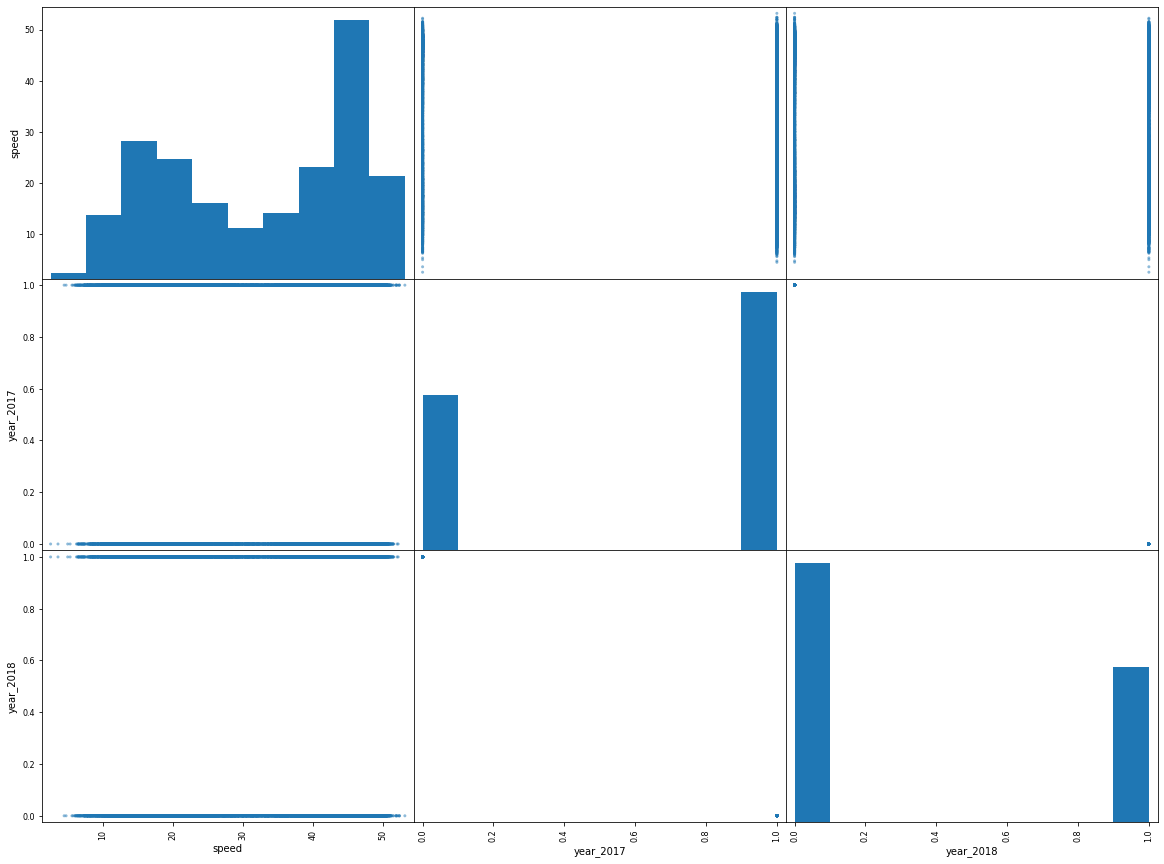

In [32]:
year_features = ['speed', 'year_2017', 'year_2018']

scatter_matrix(train_data[year_features],figsize=(20,15))
plt.show()

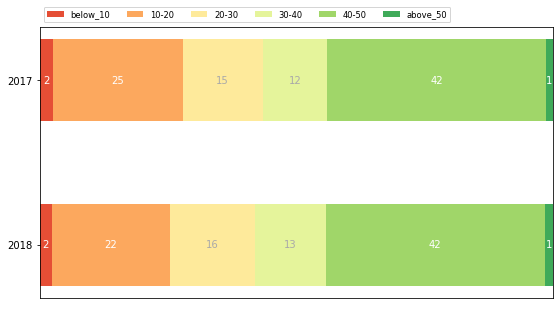

In [33]:
year_results = {
    '2017': [y2017_below_10, y2017_10_20, y2017_20_30, y2017_30_40, y2017_40_50, y2017_above_50],
    '2018': [y2018_below_10, y2018_10_20, y2018_20_30, y2018_30_40, y2018_40_50, y2018_above_50]}

survey(year_results, category_names)
plt.show()

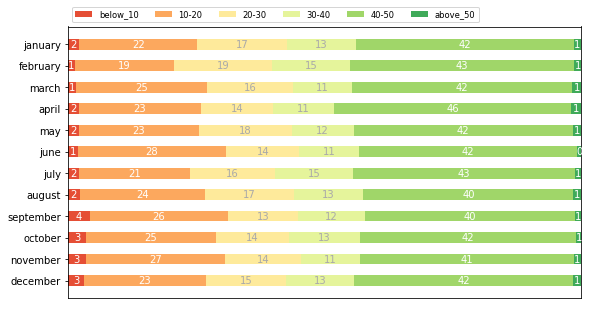

In [34]:
month_results = {
    'january': [january_below_10, january_10_20, january_20_30, january_30_40, january_40_50, january_above_50],
    'february': [february_below_10, february_10_20, february_20_30, february_30_40, february_40_50, february_above_50],
    'march': [march_below_10, march_10_20, march_20_30, march_30_40, march_40_50, march_above_50],
    'april': [april_below_10, april_10_20, april_20_30, april_30_40, april_40_50, april_above_50],
    'may': [may_below_10, may_10_20, may_20_30, may_30_40, may_40_50, may_above_50],
    'june': [june_below_10, june_10_20, june_20_30, june_30_40, june_40_50, june_above_50],
    'july': [july_below_10, july_10_20, july_20_30, july_30_40, july_40_50, july_above_50],
    'august': [august_below_10, august_10_20, august_20_30, august_30_40, august_40_50, august_above_50],
    'september': [september_below_10, september_10_20, september_20_30, september_30_40, september_40_50, september_above_50],
    'october': [october_below_10, october_10_20, october_20_30, october_30_40, october_40_50, october_above_50],
	  'november': [november_below_10, november_10_20, november_20_30, november_30_40, november_40_50, november_above_50],
    'december': [december_below_10, december_10_20, december_20_30, december_30_40, december_40_50, december_above_50]}

survey(month_results, category_names)
plt.show()

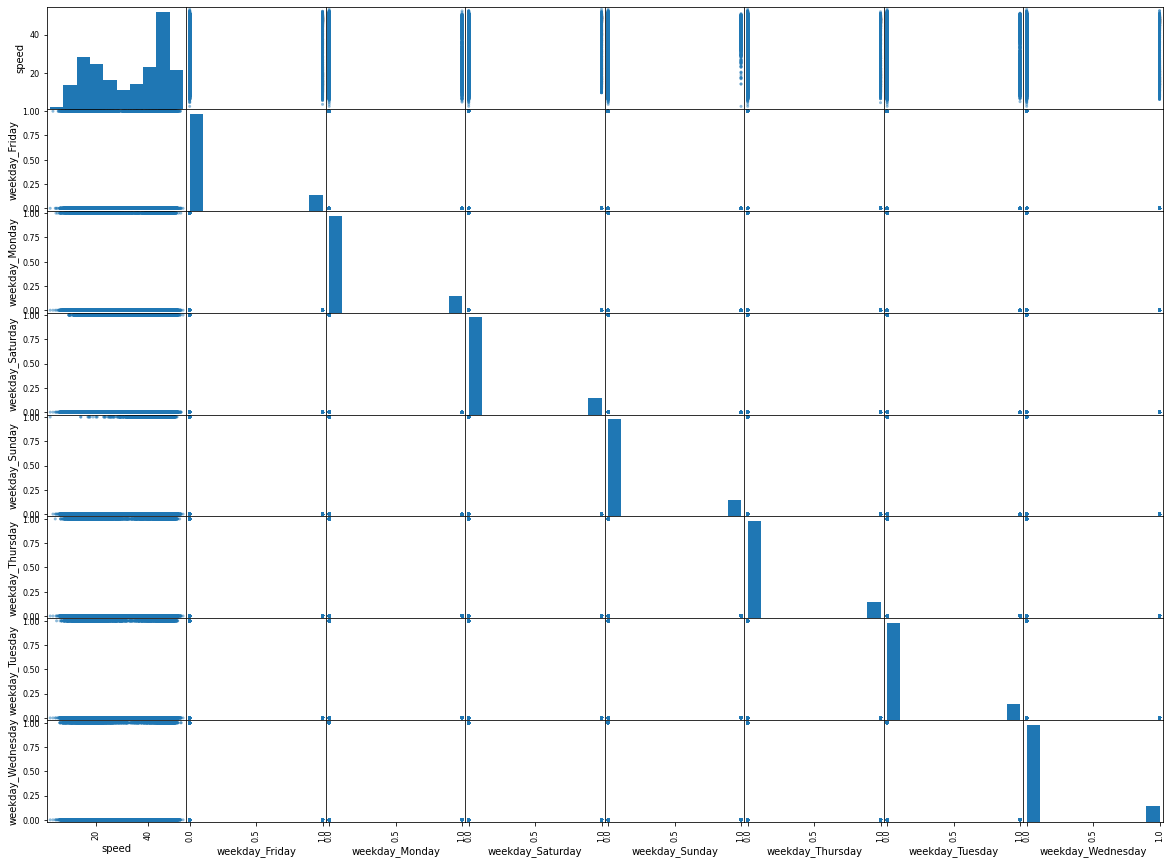

In [35]:
features = ['speed', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday']

scatter_matrix(train_data[features],figsize=(20,15))
plt.show()

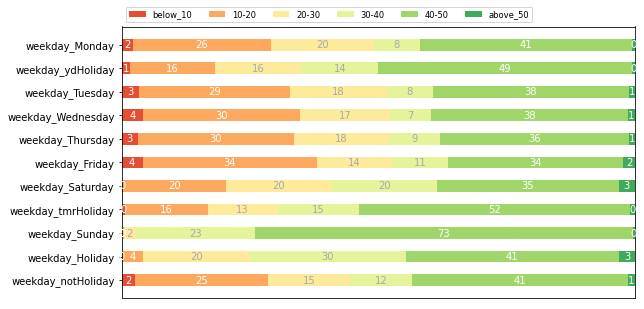

In [36]:
weekday_results = {
    'weekday_Monday': [monday_below_10, monday_10_20, monday_20_30, monday_30_40, monday_40_50, monday_above_50],
    'weekday_ydHoliday': [ydHoliday_below_10, ydHoliday_10_20, ydHoliday_20_30, ydHoliday_30_40, ydHoliday_40_50, ydHoliday_above_50],
    'weekday_Tuesday': [tuesday_below_10, tuesday_10_20, tuesday_20_30, tuesday_30_40, tuesday_40_50, tuesday_above_50],
    'weekday_Wednesday': [wednesday_below_10, wednesday_10_20, wednesday_20_30, wednesday_30_40, wednesday_40_50, wednesday_above_50],
    'weekday_Thursday': [thursday_below_10, thursday_10_20, thursday_20_30, thursday_30_40, thursday_40_50, thursday_above_50],
    'weekday_Friday': [friday_below_10, friday_10_20, friday_20_30, friday_30_40, friday_40_50, friday_above_50],
    'weekday_Saturday': [saturday_below_10, saturday_10_20, saturday_20_30, saturday_30_40, saturday_40_50, saturday_above_50],
    'weekday_tmrHoliday': [tmrHoliday_below_10, tmrHoliday_10_20, tmrHoliday_20_30, tmrHoliday_30_40, tmrHoliday_40_50, tmrHoliday_above_50],
    'weekday_Sunday': [sunday_below_10, sunday_10_20, sunday_20_30, sunday_30_40, sunday_40_50, sunday_above_50],
    'weekday_Holiday': [holiday_below_10, holiday_10_20, holiday_20_30, holiday_30_40, holiday_40_50, holiday_above_50],
    'weekday_notHoliday': [notHoliday_below_10, notHoliday_10_20, notHoliday_20_30, notHoliday_30_40, notHoliday_40_50, notHoliday_above_50]}

survey(weekday_results, category_names)
plt.show()

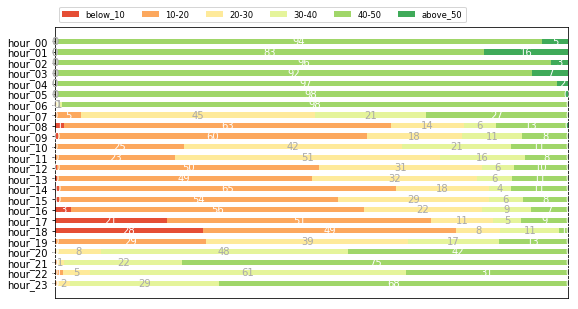

In [37]:
hour_results = {'hour_00': [hour_00_below_10, hour_00_10_20, hour_00_20_30, hour_00_30_40, hour_00_40_50, hour_00_above_50],
    'hour_01': [hour_01_below_10, hour_01_10_20, hour_01_20_30, hour_01_30_40, hour_01_40_50, hour_01_above_50],
    'hour_02': [hour_02_below_10, hour_02_10_20, hour_02_20_30, hour_02_30_40, hour_02_40_50, hour_02_above_50],
    'hour_03': [hour_03_below_10, hour_03_10_20, hour_03_20_30, hour_03_30_40, hour_03_40_50, hour_03_above_50],
    'hour_04': [hour_04_below_10, hour_04_10_20, hour_04_20_30, hour_04_30_40, hour_04_40_50, hour_04_above_50],
    'hour_05': [hour_05_below_10, hour_05_10_20, hour_05_20_30, hour_05_30_40, hour_05_40_50, hour_05_above_50],
    'hour_06': [hour_06_below_10, hour_06_10_20, hour_06_20_30, hour_06_30_40, hour_06_40_50, hour_06_above_50],
    'hour_07': [hour_07_below_10, hour_07_10_20, hour_07_20_30, hour_07_30_40, hour_07_40_50, hour_07_above_50],
    'hour_08': [hour_08_below_10, hour_08_10_20, hour_08_20_30, hour_08_30_40, hour_08_40_50, hour_08_above_50],
    'hour_09': [hour_09_below_10, hour_09_10_20, hour_09_20_30, hour_09_30_40, hour_09_40_50, hour_09_above_50],
    'hour_10': [hour_10_below_10, hour_10_10_20, hour_10_20_30, hour_10_30_40, hour_10_40_50, hour_10_above_50],
    'hour_11': [hour_11_below_10, hour_11_10_20, hour_11_20_30, hour_11_30_40, hour_11_40_50, hour_11_above_50],
    'hour_12': [hour_12_below_10, hour_12_10_20, hour_12_20_30, hour_12_30_40, hour_12_40_50, hour_12_above_50],
    'hour_13': [hour_13_below_10, hour_13_10_20, hour_13_20_30, hour_13_30_40, hour_13_40_50, hour_13_above_50],
    'hour_14': [hour_14_below_10, hour_14_10_20, hour_14_20_30, hour_14_30_40, hour_14_40_50, hour_14_above_50],
    'hour_15': [hour_15_below_10, hour_15_10_20, hour_15_20_30, hour_15_30_40, hour_15_40_50, hour_15_above_50],
    'hour_16': [hour_16_below_10, hour_16_10_20, hour_16_20_30, hour_16_30_40, hour_16_40_50, hour_16_above_50],
    'hour_17': [hour_17_below_10, hour_17_10_20, hour_17_20_30, hour_17_30_40, hour_17_40_50, hour_17_above_50],
    'hour_18': [hour_18_below_10, hour_18_10_20, hour_18_20_30, hour_18_30_40, hour_18_40_50, hour_18_above_50],
    'hour_19': [hour_19_below_10, hour_19_10_20, hour_19_20_30, hour_19_30_40, hour_19_40_50, hour_19_above_50],
    'hour_20': [hour_20_below_10, hour_20_10_20, hour_20_20_30, hour_20_30_40, hour_20_40_50, hour_20_above_50],
    'hour_21': [hour_21_below_10, hour_21_10_20, hour_21_20_30, hour_21_30_40, hour_21_40_50, hour_21_above_50],
    'hour_22': [hour_22_below_10, hour_22_10_20, hour_22_20_30, hour_22_30_40, hour_22_40_50, hour_22_above_50],
    'hour_23': [hour_23_below_10, hour_23_10_20, hour_23_20_30, hour_23_30_40, hour_23_40_50, hour_23_above_50]}

survey(hour_results, category_names)
plt.show()

In [38]:
# jan, dec # feb # mar, apr, may # june # july, aug # sep, oct, nov

train_data['month_Jan_Dec'] = np.where((train_data['month_January'] == 1) | (train_data['month_December'] == 1), 1, 0)
train_data['month_Mar_to_May'] = np.where((train_data['month_March'] == 1) | (train_data['month_April'] == 1) | (train_data['month_May'] == 1), 1, 0)
train_data['month_Jul_Aug'] = np.where((train_data['month_July'] == 1) | (train_data['month_August'] == 1), 1, 0)
train_data['month_Sep_to_Nov'] = np.where((train_data['month_September'] == 1) | (train_data['month_October'] == 1) | (train_data['month_November'] == 1), 1, 0)

# Mon, Tue, Wed, Thu, Fri, notHoliday # ydHoliday, tmrHoliday 
# Sat # Sun # Holiday

train_data['Sat_not_Holiday'] = np.where((train_data['weekday_Saturday'] == 1) & (train_data['holiday'] == 0), 1, 0)
train_data['yd_tmr_Holiday'] = np.where(((train_data['ydHoliday'] == 1) | (train_data['tmrHoliday'] == 1)) & (train_data['weekday_Saturday'] == 0) & (train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 0), 1, 0)
train_data['weekday'] = np.where((train_data['yd_tmr_Holiday'] == 0) & (train_data['weekday_Saturday'] == 0) & (train_data['weekday_Sunday'] == 0) & (train_data['holiday'] == 0), 1, 0)

# 00 # 01 # 02, 03, 04, 05, 06 # 07 # 08, 09 # 10, 11 
# 12, 13 # 14 # 15, 16 # 17, 18 # 19 # 20 # 21 # 22 # 23

train_data['hour_02_to_06'] = np.where((train_data['hour_02'] == 1) | (train_data['hour_03'] == 1) | (train_data['hour_04'] == 1) | (train_data['hour_05'] == 1) | (train_data['hour_06'] == 1), 1, 0)
train_data['hour_08_09'] = np.where((train_data['hour_08'] == 1) | (train_data['hour_09'] == 1), 1, 0)
train_data['hour_10_11'] = np.where((train_data['hour_10'] == 1) | (train_data['hour_11'] == 1), 1, 0)
train_data['hour_12_13'] = np.where((train_data['hour_12'] == 1) | (train_data['hour_13'] == 1), 1, 0)
train_data['hour_15_16'] = np.where((train_data['hour_15'] == 1) | (train_data['hour_16'] == 1), 1, 0)
train_data['hour_17_18'] = np.where((train_data['hour_17'] == 1) | (train_data['hour_18'] == 1), 1, 0)

In [39]:
corr_info1 = train_data.corr()

corr_info1 = corr_info1.drop(index='id', columns='id')
# corr_info1 = corr_info1.drop(index='weekend', columns='weekend')
corr_info1 = corr_info1.drop(index='month_Jan_Dec', columns='month_Jan_Dec')
corr_info1 = corr_info1.drop(index='month_Mar_to_May', columns='month_Mar_to_May')
corr_info1 = corr_info1.drop(index='month_Jul_Aug', columns='month_Jul_Aug')
corr_info1 = corr_info1.drop(index='month_Sep_to_Nov', columns='month_Sep_to_Nov')

corr_info1 = corr_info1.drop(index='Sat_not_Holiday', columns='Sat_not_Holiday')
corr_info1 = corr_info1.drop(index='yd_tmr_Holiday', columns='yd_tmr_Holiday')
corr_info1 = corr_info1.drop(index='weekday', columns='weekday')

corr_info1 = corr_info1.drop(index='hour_02_to_06', columns='hour_02_to_06')
corr_info1 = corr_info1.drop(index='hour_08_09', columns='hour_08_09')
corr_info1 = corr_info1.drop(index='hour_10_11', columns='hour_10_11')
corr_info1 = corr_info1.drop(index='hour_12_13', columns='hour_12_13')
corr_info1 = corr_info1.drop(index='hour_15_16', columns='hour_15_16')
corr_info1 = corr_info1.drop(index='hour_17_18', columns='hour_17_18')

# define busy hours, non busy hours may help
corr_info1

,speed,year_2017,year_2018,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday,tmrHoliday,ydHoliday
speed,1.000000,-0.015102,0.015102,0.020930,-0.005986,0.003877,0.029080,0.005698,0.011719,-0.021338,0.000011,0.001898,-0.014312,-0.007103,-0.024157,-0.087531,-0.032928,0.021776,0.288408,-0.064050,-0.060335,-0.067713,0.224402,0.238299,0.223187,0.235491,0.223970,0.214412,0.187016,-0.011953,-0.179914,-0.160063,-0.089541,-0.102393,-0.159864,-0.152344,-0.175825,-0.170472,-0.184086,-0.232621,-0.258910,-0.099157,0.083443,0.146387,0.067396,0.133839,0.073575,0.054713,0.037646
year_2017,-0.015102,1.000000,-1.000000,0.000501,0.004285,0.011687,-0.006636,-0.002482,-0.007435,0.000166,-0.002335,-0.010794,0.004887,0.009655,-0.001174,0.004403,-0.004085,-0.006800,0.002638,-0.003768,0.004884,0.002817,0.001689,0.001689,0.002895,-0.002915,-0.001082,0.003552,0.001689,0.000762,-0.004457,0.002895,-0.000805,-0.004003,0.003827,0.001965,0.010444,0.003827,-0.004735,-0.004003,0.001039,-0.000805,-0.008510,-0.004003,-0.002000,0.001689,0.001788,0.000211,0.002228
year_2018,0.015102,-1.000000,1.000000,-0.000501,-0.004285,-0.011687,0.006636,0.002482,0.007435,-0.000166,0.002335,0.010794,-0.004887,-0.009655,0.001174,-0.004403,0.004085,0.006800,-0.002638,0.003768,-0.004884,-0.002817,-0.001689,-0.001689,-0.002895,0.002915,0.001082,-0.003552,-0.001689,-0.000762,0.004457,-0.002895,0.000805,0.004003,-0.003827,-0.001965,-0.010444,-0.003827,0.004735,0.004003,-0.001039,0.000805,0.008510,0.004003,0.002000,-0.001689,-0.001788,-0.000211,-0.002228
month_April,0.020930,0.000501,-0.000501,1.000000,-0.090677,-0.089749,-0.087142,-0.090928,-0.092098,-0.089580,-0.091514,-0.092596,-0.088985,-0.090002,-0.089749,-0.004325,0.003574,0.005795,0.021068,-0.005444,-0.007009,-0.013906,0.000546,-0.002066,0.000654,-0.000523,-0.002696,0.000979,0.007076,0.000331,-0.003631,-0.001960,0.002393,0.000346,0.006107,0.006963,-0.001569,-0.000439,0.000346,-0.006110,0.001526,0.001095,-0.001990,-0.002236,-0.004202,-0.000760,0.093576,0.133503,0.109835
month_August,-0.005986,0.004285,-0.004285,-0.090677,1.000000,-0.090891,-0.088251,-0.092085,-0.093270,-0.090719,-0.092679,-0.093774,-0.090117,-0.091148,-0.090891,-0.005622,-0.011780,-0.016149,-0.012725,0.014505,0.013897,0.018133,0.002975,-0.003486,0.000500,-0.001972,0.003597,0.000828,-0.003486,0.006623,-0.005054,-0.003380,0.008625,-0.007506,-0.004463,-0.002301,-0.000351,-0.001873,0.002714,0.002714,-0.001225,0.002201,0.005429,0.001437,0.002092,-0.004778,-0.066798,-0.069034,-0.066744
month_December,0.003877,0.011687,-0.011687,-0.089749,-0.090891,1.000000,-0.087348,-0.091143,-0.092316,-0.089791,-0.091731,-0.092815,-0.089196,-0.090215,-0.089961,0.004837,-0.002144,0.018539,0.013116,-0.017061,-0.014230,-0.003232,0.000276,0.000276,-0.004834,-0.002086,0.002226,-0.003215,0.000276,0.000061,0.002541,-0.002225,-0.001770,0.002649,0.000600,0.001470,-0.000509,0.003213,0.006515,-0.006370,-0.000047,-0.000474,-0.000983,0.002649,0.000714,-0.001028,0.022752,0.064656,0.024106
month_February,0.029080,-0.006636,0.006636,-0.087142,-0.088251,-0.087348,1.000000,-0.088496,-0.089635,-0.087183,-0.089067,-0.090119,-0.086605,-0.087595,-0.087348,0.003147,-0.000109,0.002208,-0.006347,-0.000227,0.001157,0.000214,-0.003028,0.000980,0.001085,0.001261,-0.002308,-0.005300,0.000980,0.000770,-0.000580,-0.001589,0.001575,0.002165,-0.000043,0.000875,0.002795,0.002636,-0.001798,0.002165,0.001997,-0.001081,0.002433,-0.003119,-0.001184,-0.001692,-0.004731,-0.007396,0.019421
month_January,0.005698,-0.002482,0.002482,-0.090928,-0.092085,-0.091143,-0.088496,1.000000,-0.093529,-0.090971,-0.092936,-0.0

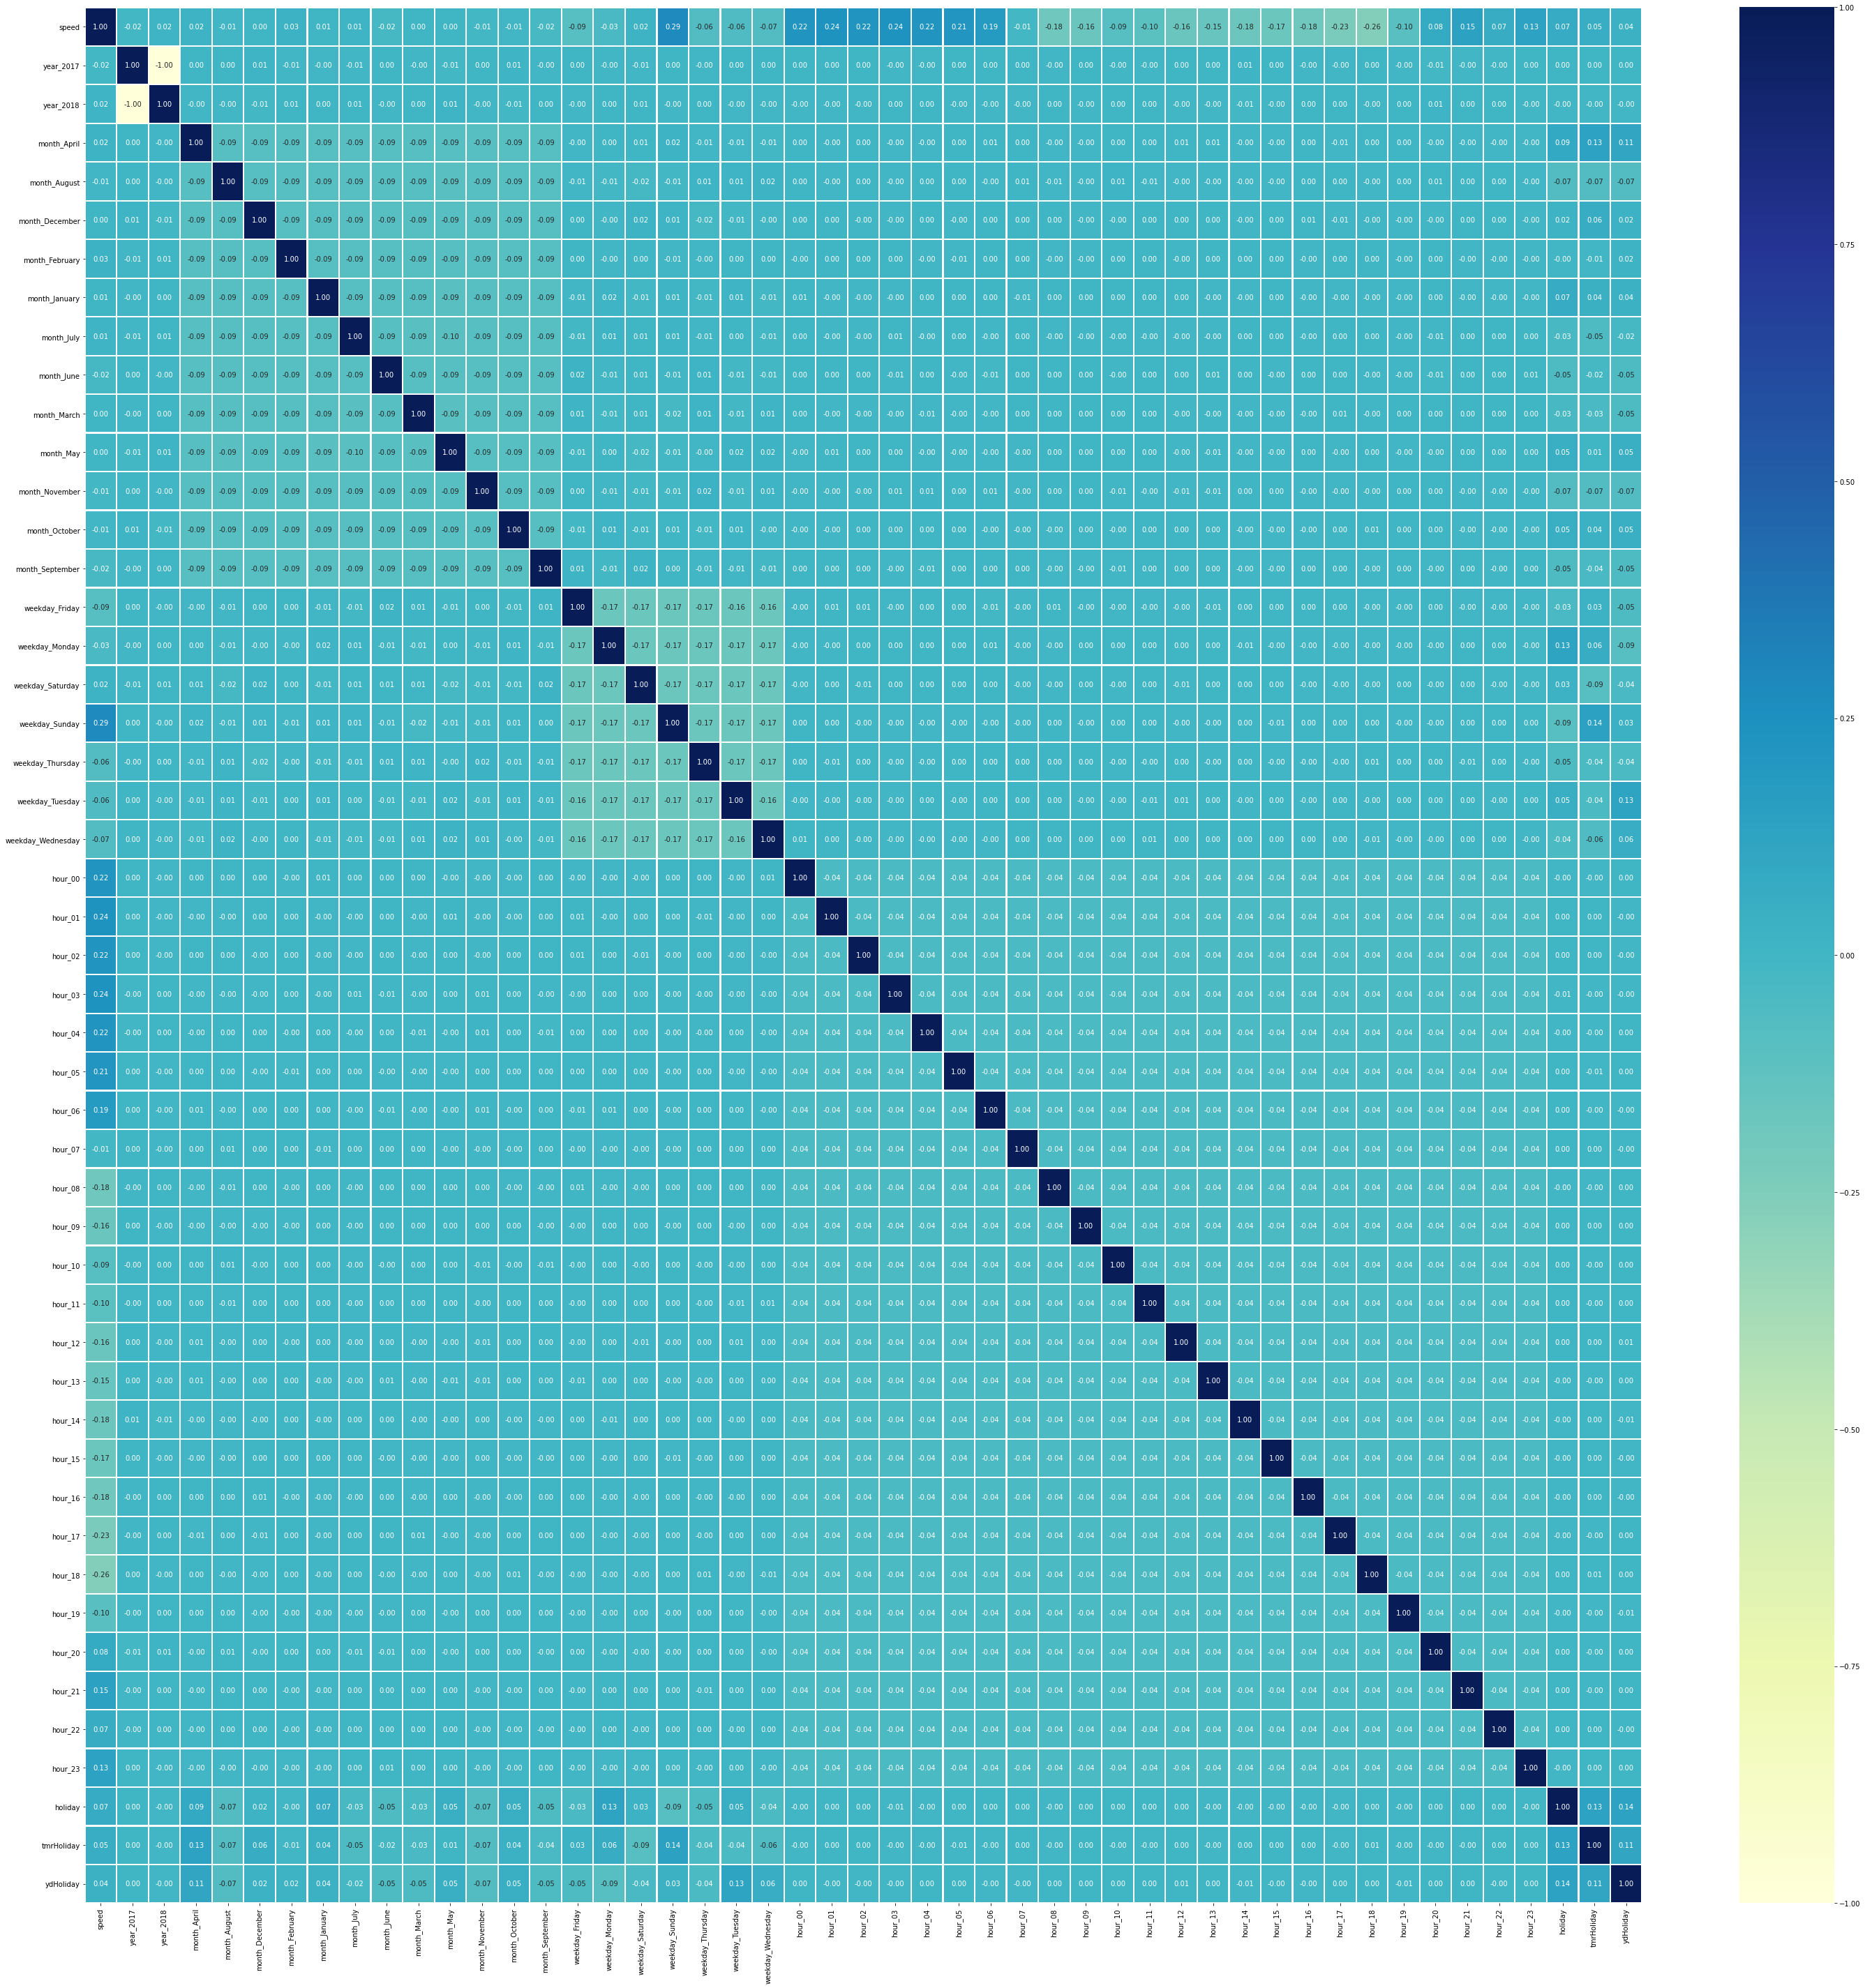

In [40]:
# Print the Co-relation Map
fig,ax = plt.subplots(figsize = (50,50))
ax = sns.heatmap(corr_info1, annot=True, linewidths=1.2, fmt=".2f", cmap="YlGnBu")

In [41]:
corr_info2 = train_data.corr()

corr_info2 = corr_info2.drop(index='id', columns='id')
# corr_info2 = corr_info2.drop(index='weekend', columns='weekend')
corr_info2 = corr_info2.drop(index='year_2017', columns='year_2017')
corr_info2 = corr_info2.drop(index='year_2018', columns='year_2018')
corr_info2 = corr_info2.drop(index='month_January', columns='month_January')
corr_info2 = corr_info2.drop(index='month_March', columns='month_March')
corr_info2 = corr_info2.drop(index='month_April', columns='month_April')
corr_info2 = corr_info2.drop(index='month_May', columns='month_May')
corr_info2 = corr_info2.drop(index='month_July', columns='month_July')
corr_info2 = corr_info2.drop(index='month_August', columns='month_August')
corr_info2 = corr_info2.drop(index='month_September', columns='month_September')
corr_info2 = corr_info2.drop(index='month_October', columns='month_October')
corr_info2 = corr_info2.drop(index='month_November', columns='month_November')
corr_info2 = corr_info2.drop(index='month_December', columns='month_December')

corr_info2 = corr_info2.drop(index='weekday_Monday', columns='weekday_Monday')
corr_info2 = corr_info2.drop(index='weekday_Tuesday', columns='weekday_Tuesday')
corr_info2 = corr_info2.drop(index='weekday_Wednesday', columns='weekday_Wednesday')
corr_info2 = corr_info2.drop(index='weekday_Thursday', columns='weekday_Thursday')
corr_info2 = corr_info2.drop(index='weekday_Friday', columns='weekday_Friday')
corr_info2 = corr_info2.drop(index='weekday_Saturday', columns='weekday_Saturday')
corr_info2 = corr_info2.drop(index='ydHoliday', columns='ydHoliday')
corr_info2 = corr_info2.drop(index='tmrHoliday', columns='tmrHoliday')

corr_info2 = corr_info2.drop(index='hour_02', columns='hour_02')
corr_info2 = corr_info2.drop(index='hour_03', columns='hour_03')
corr_info2 = corr_info2.drop(index='hour_04', columns='hour_04')
corr_info2 = corr_info2.drop(index='hour_05', columns='hour_05')
corr_info2 = corr_info2.drop(index='hour_06', columns='hour_06')
corr_info2 = corr_info2.drop(index='hour_08', columns='hour_08')
corr_info2 = corr_info2.drop(index='hour_09', columns='hour_09')
corr_info2 = corr_info2.drop(index='hour_10', columns='hour_10')
corr_info2 = corr_info2.drop(index='hour_11', columns='hour_11')
corr_info2 = corr_info2.drop(index='hour_12', columns='hour_12')
corr_info2 = corr_info2.drop(index='hour_13', columns='hour_13')
corr_info2 = corr_info2.drop(index='hour_15', columns='hour_15')
corr_info2 = corr_info2.drop(index='hour_16', columns='hour_16')
corr_info2 = corr_info2.drop(index='hour_17', columns='hour_17')
corr_info2 = corr_info2.drop(index='hour_18', columns='hour_18')

# define busy hours, non busy hours may help
corr_info2

,speed,month_February,month_June,weekday_Sunday,hour_00,hour_01,hour_07,hour_14,hour_19,hour_20,hour_21,hour_22,hour_23,holiday,month_Jan_Dec,month_Mar_to_May,month_Jul_Aug,month_Sep_to_Nov,Sat_not_Holiday,yd_tmr_Holiday,weekday,hour_02_to_06,hour_08_09,hour_10_11,hour_12_13,hour_15_16,hour_17_18
speed,1.000000,0.029080,-0.021338,0.288408,0.224402,0.238299,-0.011953,-0.175825,-0.099157,0.083443,0.146387,0.067396,0.133839,0.073575,0.007109,0.014423,0.004343,-0.029033,0.009193,-0.023838,-0.237030,0.533261,-0.245915,-0.138828,-0.225666,-0.256416,-0.355344
month_February,0.029080,1.000000,-0.087183,-0.006347,-0.003028,0.000980,0.000770,0.002795,-0.001081,0.002433,-0.003119,-0.001184,-0.001692,-0.004731,-0.130429,-0.170427,-0.132098,-0.166682,-0.000957,-0.000048,0.007357,-0.002094,-0.001564,0.002706,0.000602,0.000583,0.003010
month_June,-0.021338,-0.087183,1.000000,-0.006383,0.000492,0.004408,0.002883,0.002351,-0.001556,-0.008446,0.001582,0.000932,0.005714,-0.049919,-0.134077,-0.175194,-0.135793,-0.171344,0.015232,-0.024863,0.026747,-0.008344,0.002442,-0.000911,0.005589,-0.000142,-0.000604
weekday_Sunday,0.288408,-0.006347,-0.006383,1.000000,0.001271,0.001271,-0.001062,0.001764,-0.000777,-0.004225,0.001231,0.002116,0.003310,-0.090648,0.016059,-0.002721,-0.000388,-0.002786,-0.162719,-0.094606,-0.529069,-0.003684,-0.001123,0.003988,-0.000898,-0.002274,0.002221
hour_00,0.224402,-0.003028,0.000492,0.001271,1.000000,-0.043122,-0.043200,-0.042457,-0.043393,-0.044046,-0.043663,-0.043432,-0.043122,-0.001415,0.004101,-0.001403,0.003050,-0.003219,-0.000398,-0.001811,0.000789,-0.106252,-0.062753,-0.062957,-0.062284,-0.062665,-0.062840
hour_01,0.238299,0.000980,0.004408,0.001271,-0.043122,1.000000,-0.043200,-0.042457,-0.043393,-0.044046,-0.043663,-0.043432,-0.043122,0.001997,-0.000706,0.000242,-0.002671,-0.000723,0.002747,-0.000169,-0.003652,-0.106252,-0.062753,-0.062957,-0.062284,-0.062665,-0.062840
hour_07,-0.011953,0.000770,0.002883,-0.001062,-0.043200,-0.043200,1.000000,-0.042534,-0.043471,-0.044125,-0.043742,-0.043510,-0.043200,0.003540,-0.003905,-0.000177,0.005575,-0.003623,-0.002774,0.001305,0.000605,-0.106443,-0.062866,-0.063070,-0.062396,-0.062778,-0.062953
hour_14,-0.175825,0.002795,0.002351,0.001764,-0.042457,-0.042457,-0.042534,1.000000,-0.042724,-0.043367,-0.042990,-0.042762,-0.042457,-0.001803,-0.000872,-0.001977,0.001063,-0.001413,0.003107,-0.002079,-0.001755,-0.104614,-0.061786,-0.061987,-0.061324,-0.061699,-0.061872
hour_19,-0.099157,-0.001081,-0.001556,-0.000777,-0.043393,-0.043393,-0.043471,-0.042724,1.000000,-0.044323,-0.043938,-0.043705,-0.043393,-0.003653,-0.001820,0.002870,-0.001892,0.001988,0.004871,-0.004006,0.000517,-0.106920,-0.063147,-0.063353,-0.062676,-0.063059,-0.063236
hour_20,0.083443,0.002433,-0.008446,-0.004225,-0.044046,-0.044046,-0.044125,-0.043367,-0.044323,1.000000,-0.044599,-0.044363,-0.044046,0.001771,0.002127,-0.002282,0.000097,0.004250,-0.002702,0.002722,0.002980,-0.108529,-0.064097,-0.064306,-0.063619,-0.064008,-0.064187


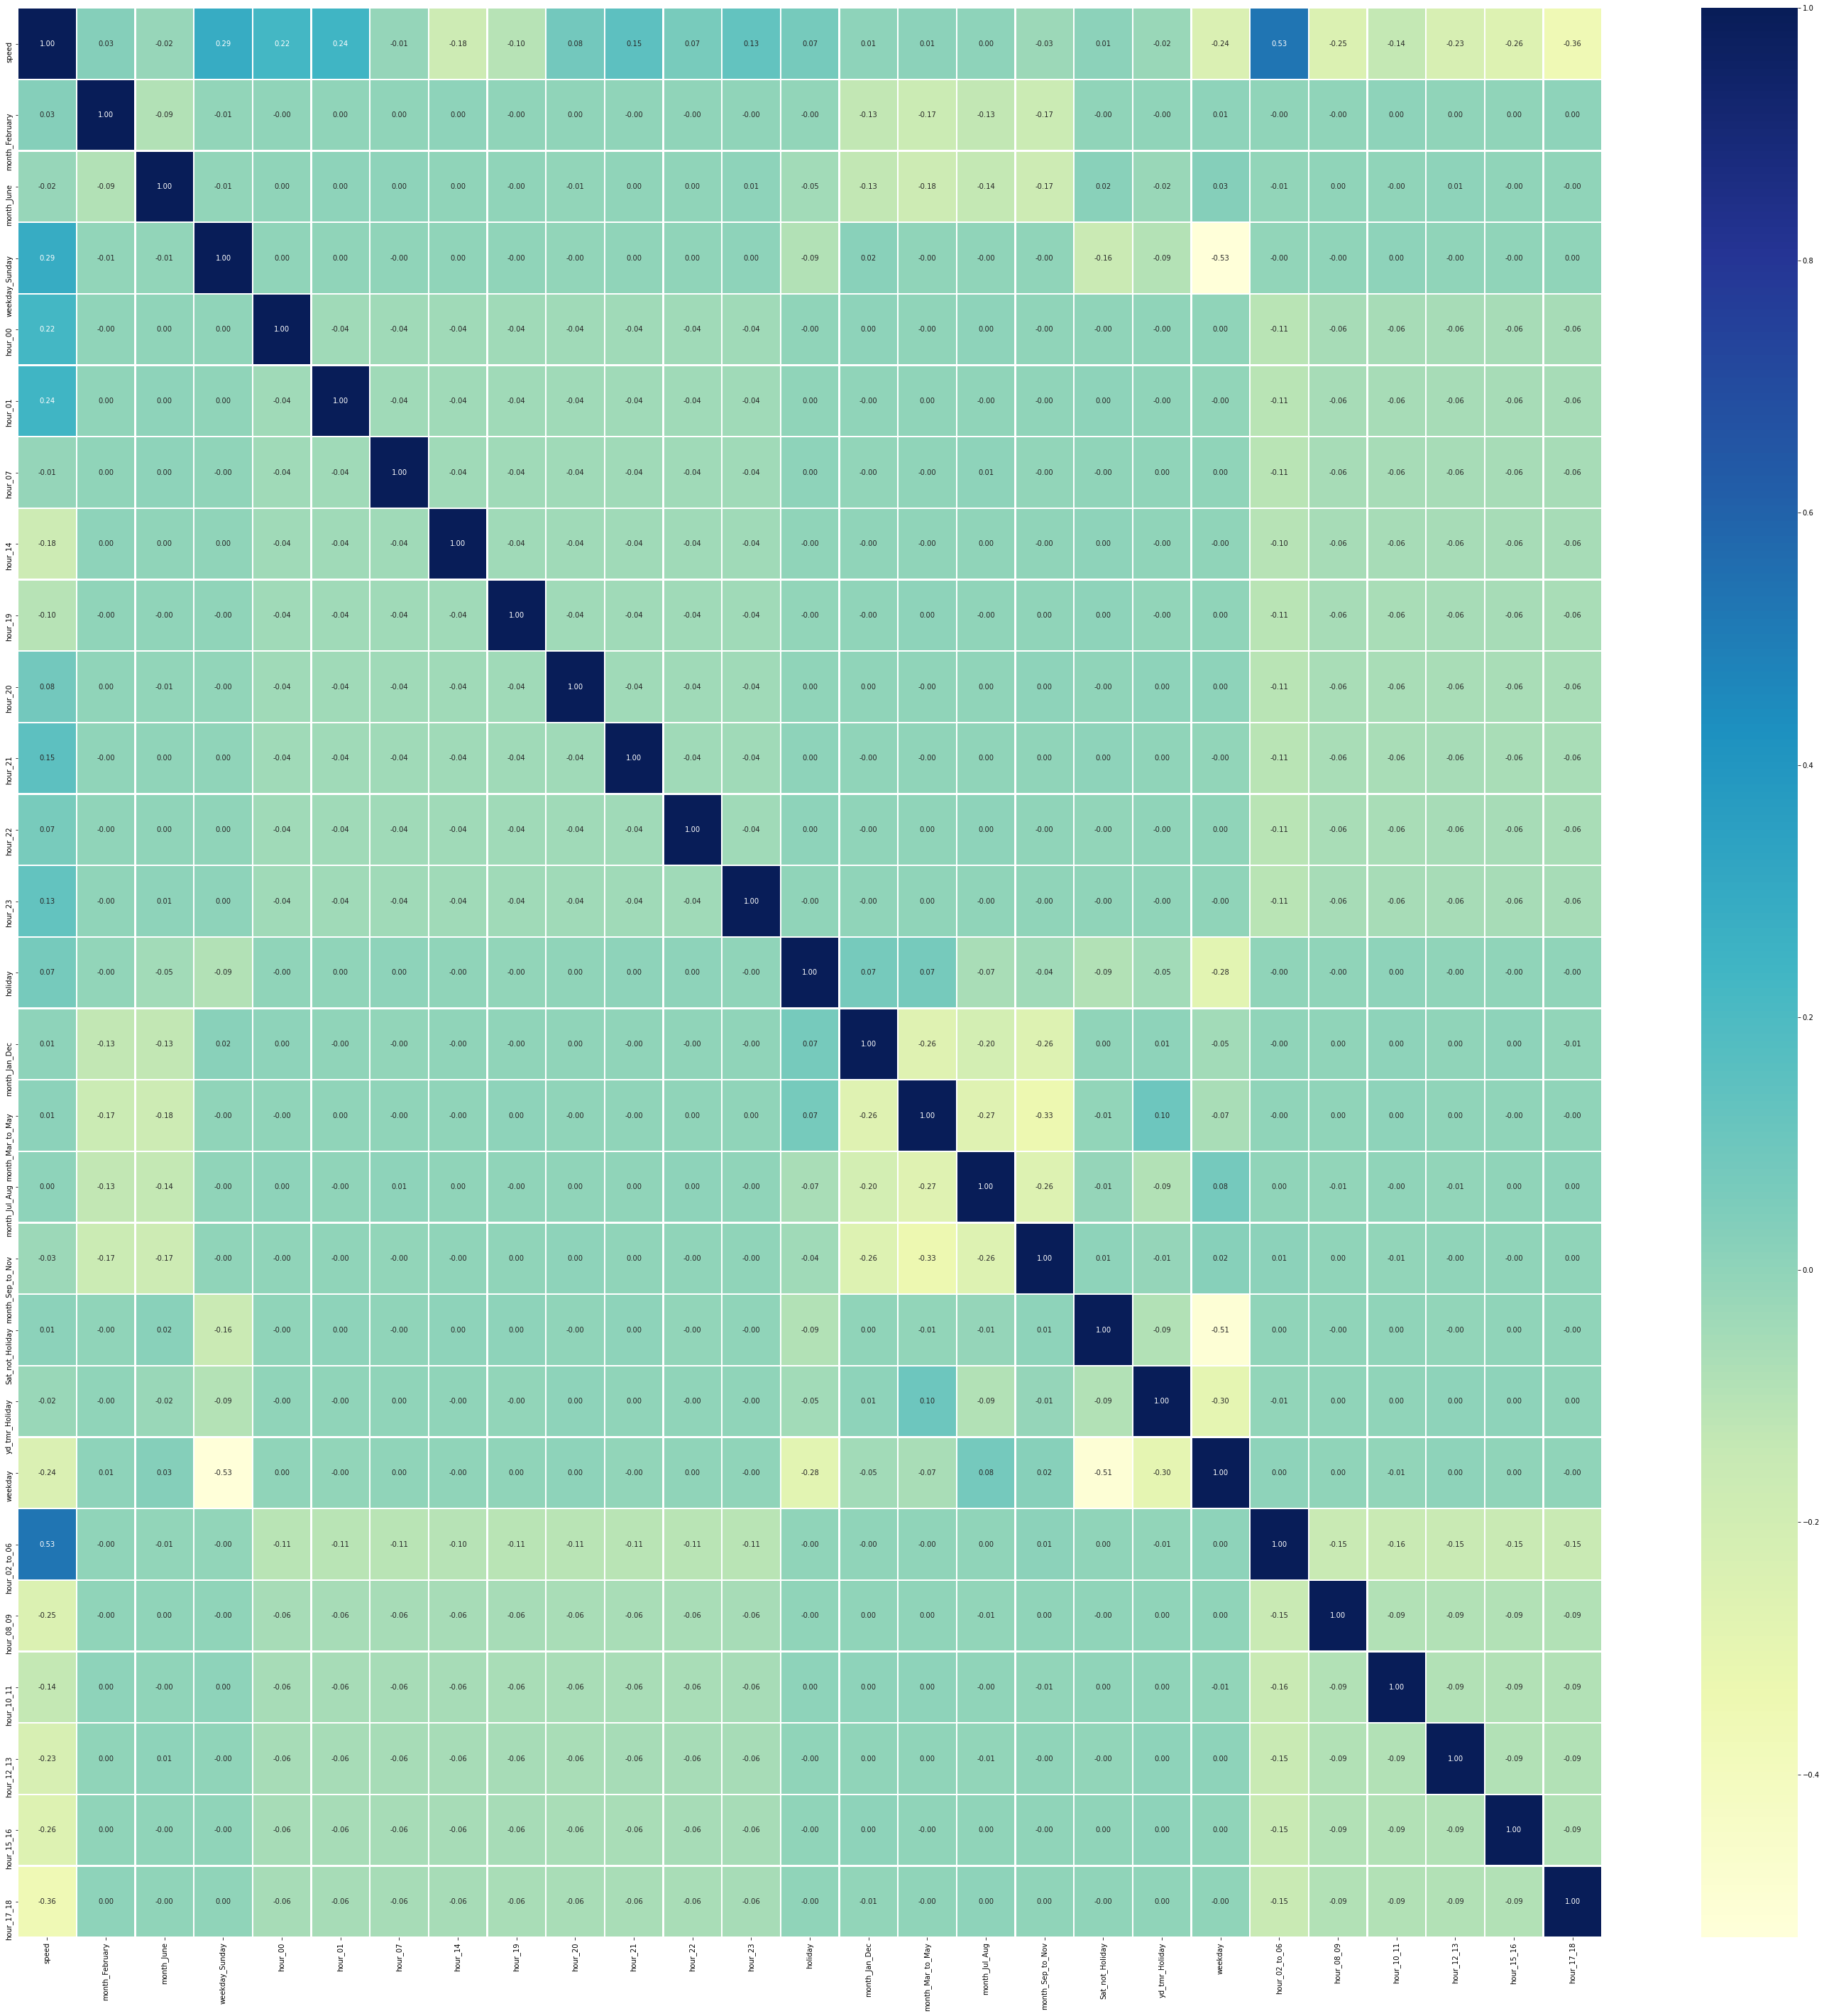

In [42]:
# Print the Co-relation Map
fig,ax = plt.subplots(figsize = (50,50))
ax = sns.heatmap(corr_info2, annot=True, linewidths=1.2, fmt=".2f", cmap="YlGnBu")

In [43]:
# Output as a pkl file
train_data.to_pickle('train_data_prepared.pkl')